<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [55]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7,activation='LeakyReLU',use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(14*14,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='sigmoid',use_bias=False))
    model.add(layers.Reshape((28,28,1)))

    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(input_img)

    x = layers.Dropout(.2)(x)

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(1, activation='linear')(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model



In [85]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0004)

In [42]:
BATCH_SIZE = 10

#@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminator(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [76]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    for i in range(2):
      with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(images, generated_images)
        disc_loss += gp * GP_WEIGHT
      if i ==0:
         weights = discriminator.get_weights()

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminator.set_weights(weights)
    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)

In [80]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        gp = gradient_penalty(images, generated_images)
        disc_loss += gp * GP_WEIGHT
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)

In [81]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [98]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_loss -0.6877473 gen_loss -0.565068185
disc_loss 0.0617494583 gen_loss -0.858976543
disc_loss -0.637523413 gen_loss -0.335009
disc_loss -0.230897769 gen_loss -0.433549404
disc_loss -0.558618665 gen_loss -0.951143861
disc_loss -0.971274257 gen_loss -0.692563474
disc_loss -1.14646268 gen_loss -0.868812561
disc_loss -0.439335108 gen_loss -0.617647052
disc_loss -0.699321687 gen_loss -1.0148375
disc_loss -0.58298707 gen_loss -0.584854126
disc_loss -0.885153294 gen_loss -1.25227153
disc_loss -0.261946678 gen_loss -1.40355659
disc_loss -0.914548874 gen_loss -1.29506993
disc_loss -0.173566371 gen_loss -1.50447524
disc_loss -0.0770517513 gen_loss -1.49528718
disc_loss -0.297637522 gen_loss -1.84519863
disc_loss -0.110452026 gen_loss -1.69349062
disc_loss -0.304518938 gen_loss -1.82390785
disc_loss -0.713232875 gen_loss -1.52389991
disc_loss 0.174886495 gen_loss -2.49782228
disc_loss -0.686526716 gen_loss -1.8145771
disc_loss -0.659201384 gen_loss -1.98272669
disc_loss -0.984640539 gen_loss 

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 33ms/step


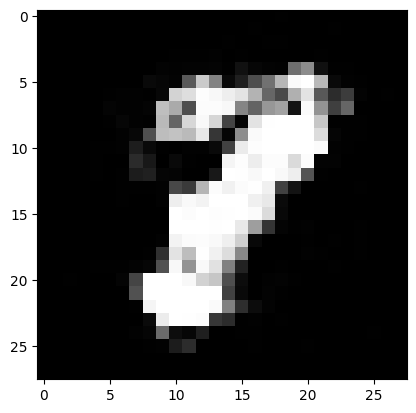

In [105]:
noise = tf.random.normal(shape=(1,100))
test = generator.predict(noise)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))